## Dermnet - Kamień milowy 3 (Modelowanie)

### 0. Pakiety

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import img_to_array
import cv2
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score, pairwise_distances
from functools import partial
from scipy.spatial import distance


## 1. Przygotowanie danych
### 1.1. Import

In [3]:
df1 = pd.read_pickle('train_data_1.pkl')
df2 = pd.read_pickle('train_data_2.pkl')
X = pd.concat([df1, df2], axis=0)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15557 entries, 0 to 15556
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   15557 non-null  object
dtypes: object(1)
memory usage: 121.7+ KB


Zmiana rozdzielczości z 224x224 px na 75x75 px.

In [4]:
# resize all images
X['image'] = X['image'].apply(lambda x: cv2.resize(x, (75, 75)))

### 1.2. Rotacja

In [ ]:
# def rotate_all_images(data_frame, colname = 'image'):
#     images_90 = []
#     for image in data_frame[colname]:
#         image_90 = np.rot90(image)
#         images_90.append(image_90)
#     return pd.DataFrame({colname: images_90})


In [ ]:
# X_rotated_90 = rotate_all_images(X)
# X_rotated_180 = rotate_all_images(X_rotated_90)
# X_rotated_270 = rotate_all_images(X_rotated_180)

### 1.3. Modyfikacje obrazów
#### Funkcje

In [ ]:
# random.seed(2137)
# chosen_indexes = random.sample(range(len(X['image'])), 8)

# def visualize_random_images(df, indexes = [0, 1, 2, 3, 4, 5, 6, 7]):
#     fig, axes = plt.subplots(2, 4, figsize=(20, 10))
#     for i in range(8):
#         img = df['image'].iloc[indexes[i]]
#         ax = axes[i//4, i%4]
#         ax.imshow(img)
#         ax.axis('off')


# def convert_to_grayscale(data_frame, colname='image'):
#     '''
#     Convert the RGB images to grayscale
#     '''
#     result = []
#     k=0
#     for image in data_frame['image']:
#         r, g, b = image[:,:,0], image[:,:,1], image[:,:,2]
#         gray = 0.33 * r + 0.33 * g + 0.33 * b
#         result.append(gray)
#     result = pd.DataFrame({colname : result})
#     return result

# def convert_to_grayscale_one_color(data_frame, colname='image'):
#     '''
#     Convert the RGB images to grayscale
#     '''
#     result = []
#     k=0
#     for image in data_frame['image']:
#         r, g, b = image[:,:,0], image[:,:,1], image[:,:,2]
#         gray = r + g + b
#         result.append(gray)
#     result = pd.DataFrame({colname : result})
#     return result


# def visualize_random_images_grey(df, indexes = [0, 1, 2, 3, 4, 5, 6, 7]):
#     fig, axes = plt.subplots(2, 4, figsize=(20, 10))
#     for i in range(8):
#         img = df['image'].iloc[indexes[i]]
#         ax = axes[i//4, i%4]
#         ax.imshow(img, cmap='gray')
#         ax.axis('off')


# def extract_rgb_channel(data_frame, colname='image', color='red'):
#     '''
#     Convert the RGB images to grayscale
#     '''
#     if color == 'red':
#         channel = 0
#     elif color == 'green':
#         channel = 1
#     elif color == 'blue':
#         channel = 2
#     result = []
#     k=0
#     for image in data_frame['image']:
#         modified_image = np.zeros_like(image)
#         modified_image[:,:,channel] = image[:,:,channel]
#         result.append(modified_image)
#     result = pd.DataFrame({colname : result})
#     return result


# def global_threshold(df, tresh, colname = 'image'):
#     '''
#     Runs threshold on all images in df
#     '''
#     assert df[colname].iloc[0].ndim == 2, "images must be in greyscale"
#     result = []
#     for image in df[colname]:
#         result.append((image > tresh) * 255)
#     result = pd.DataFrame({colname : result})
#     return result

# def reverse_threshold(df, tresh, colname = 'image'):
#     '''
#     Runs threshold on all images in df
#     '''
#     assert df[colname].iloc[0].ndim == 2, "images must be in greyscale"
#     result = []
#     for image in df[colname]:
#         result.append((image < tresh) * 255)
#     result = pd.DataFrame({colname : result})
#     return result

# def detect_images(df, low_th = 50, high_th = 150, blur_ksize = 5, colname = 'image'):
#     '''
#     Runs edge detection on all images in df
#     '''
#     assert df[colname].iloc[0].ndim == 2, "images must be in greyscale"
#     result = []
#     for image in df[colname]:
#         image = (image * 255).astype(np.uint8)
#         blurred_image = cv2.GaussianBlur(image, (blur_ksize, blur_ksize), 0)

#         edges = cv2.Canny(blurred_image, low_th, high_th)  
#         result.append(edges)
#     result = pd.DataFrame({colname : result})
#     return result

# def convert_to_negative_image(df, colname = 'image'):
#     '''
#     Converts the image to negative
#     '''
#     result = []
#     for image in df[colname]:
#         result.append(255 - image)
#     result = pd.DataFrame({colname : result})
#     return result

# def erosion(df, kernel_size=(5,5), iterations=1, colname='image'):
#     result = []
#     kernel = np.ones(kernel_size, np.uint8)
#     for image in df[colname]:
#         eroded_image = cv2.erode(image, kernel, iterations=iterations)
#         result.append(eroded_image)
#     result = pd.DataFrame({colname: result})
#     return result

# def dilation(df, kernel_size=(5,5), iterations=1, colname='image'):
#     result = []
#     kernel = np.ones(kernel_size, np.uint8)
#     for image in df[colname]:
#         dilated_image = cv2.dilate(image, kernel, iterations=iterations)
#         result.append(dilated_image)
#     result = pd.DataFrame({colname: result})
#     return result

# def reverse_hough_transform(df, threshold=100, colname='image'):
#     assert df[colname].iloc[0].ndim == 2, "images must be in greyscale"
#     result = []
#     for image in df[colname]:
#         image = image.astype(np.uint8)  # Convert to CV_8U data type
#         edges = cv2.Canny(image, 50, 150, apertureSize=3)
#         lines = cv2.HoughLines(edges, 1, np.pi/180, threshold)  # Define 'lines' variable
#         if lines is not None:
#             for rho, theta in lines[:, 0]:
#                 a = np.cos(theta)
#                 b = np.sin(theta)
#                 x0 = a * rho
#                 y0 = b * rho
#                 x1 = int(x0 + 1000 * (-b))
#                 y1 = int(y0 + 1000 * (a))
#                 x2 = int(x0 - 1000 * (-b))
#                 y2 = int(y0 - 1000 * (a))
#                 cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
#         result.append(image)
#     result = pd.DataFrame({colname: result})
#     return result

# def flatten_images(df, colname='image', batch_size=100):
#     num_images = len(df)
#     flattened_data = []
#     for start in range(0, num_images, batch_size):
#         end = min(start + batch_size, num_images)
#         batch_images = df[colname].iloc[start:end]
#         batch_flattened = []
#         for image in batch_images:
#             image_array = img_to_array(image)
#             batch_flattened.append(image_array.flatten() / 255.0)
#         batch_flattened = np.array(batch_flattened)
#         flattened_data.append(batch_flattened)
#     flattened_data = np.concatenate(flattened_data, axis=0)
#     flattened_df = pd.DataFrame(flattened_data, columns=[f'{colname}_{i}' for i in range(flattened_data.shape[1])])
#     return flattened_df


# def modify_pictures(df, colname='image'):

#     # convert and flatten
#     grayscale = convert_to_grayscale(df, colname)
#     grayscale_flatten = flatten_images(grayscale, colname)
#     print('grayscale done')
#     red = extract_rgb_channel(df, colname, 'red')
#     red_flatten = flatten_images(red, colname)
#     print('red done')
#     green = extract_rgb_channel(df, colname, 'green')
#     green_flatten = flatten_images(green, colname)
#     print('green done')
#     blue = extract_rgb_channel(df, colname, 'blue')
#     blue_flatten = flatten_images(blue, colname)
#     print('blue done')
#     thresholded = global_threshold(grayscale, 100, colname)
#     thresholded_flatten = flatten_images(thresholded, colname)
#     print('threshold done') 
#     eroded = erosion(df, colname=colname)
#     eroded_flatten = flatten_images(eroded, colname)
#     print('eroded done')
#     dilated = dilation(df, colname=colname)
#     dilated_flatten = flatten_images(dilated, colname)
#     print('dilated done')
#     hough = reverse_hough_transform(grayscale, colname=colname)
#     hough_flatten = flatten_images(hough, colname)
#     print('hough done')

#     # concatenate
#     result = pd.concat([grayscale_flatten, red_flatten, green_flatten, blue_flatten, thresholded_flatten, eroded_flatten, dilated_flatten, hough_flatten], axis=1)
#     return result


### 1.3.1. Ramka danych `X`
Obrazy z wyciągniętymi kanałami R, G i B niosą w sumie te same informacje, co obraz kolorowy czy negatyw. Nie będziemy więc tych dwóch modyfikacji uwzględniać. Dzięki temu zmniejszamy liczbę 'kolumn' w docelowej ramce danych o 40%, niosąc te same informacje.

In [ ]:
# X_processed = modify_pictures(X)

grayscale done
red done
green done
blue done
threshold done
eroded done
dilated done
hough done


### 1.3.2. Ramka obrazów obróconych `X_rotated_alpha`


In [ ]:
# X_rot_90_processed = modify_pictures(X_rotated_90)
# print('90 done')
# X_rot_180_processed = modify_pictures(X_rotated_180)
# print('180 done')
# X_rot_270_processed = modify_pictures(X_rotated_270)

grayscale done
red done
green done
blue done
threshold done
eroded done
dilated done
hough done
90 done
grayscale done
red done
green done
blue done
threshold done
eroded done
dilated done
hough done
180 done
grayscale done
red done
green done
blue done
threshold done
eroded done
dilated done
hough done


### 1.4. PCA na `X`

In [ ]:
# pca = PCA(n_components = 0.9)
# X_pca = pca.fit_transform(X_processed)

In [ ]:
# X_pca.shape

(15557, 239)

In [ ]:
# X_pca_df = pd.DataFrame(X_pca)
# X_pca_df.to_csv('X_pca.csv', index=False)

### 1.5. PCA na `X_rotated_alpha`

In [5]:
# import dask.dataframe as dd

# # Convert pandas DataFrames to Dask DataFrames
# dX_processed = dd.from_pandas(X_processed, npartitions=10)
# dX_rot_90_processed = dd.from_pandas(X_rot_90_processed, npartitions=10)
# dX_rot_180_processed = dd.from_pandas(X_rot_180_processed, npartitions=10)
# dX_rot_270_processed = dd.from_pandas(X_rot_270_processed, npartitions=10)

# # Concatenate Dask DataFrames
# dX_rot_processed = dd.concat([dX_processed, dX_rot_90_processed, dX_rot_180_processed, dX_rot_270_processed], axis=0)

# # Compute the final result
# X_rot_processed = dX_rot_processed.compute()

---
## Modele
Wczytanie danych

In [6]:
X_pca = pd.read_csv('X_pca.csv')

### Funkcje

In [7]:
def count_clustering_scores(X, cluster_num, model, score_fun):
    # Napiszmy tę funkcje tak ogólnie, jak to możliwe. 
    # Zwróćcie uwagę na przekazanie obiektów typu callable: model i score_fun.
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

def calculate_dunn_index(X, labels):
    unique_cluster_labels = np.unique(labels)
    num_clusters = len(unique_cluster_labels)

    if num_clusters < 2:
        return float('inf')  # Dunn index is not defined for less than 2 clusters

    inter_cluster_distances = []
    intra_cluster_distances = []

    for i in unique_cluster_labels:
        cluster_i = X[labels == i]
        if len(cluster_i) > 1:
            intra_cluster_distances.append(np.max(pairwise_distances(cluster_i)))

        for j in unique_cluster_labels:
            if i < j:
                cluster_j = X[labels == j]
                if len(cluster_j) > 0:
                    inter_cluster_distances.append(np.min(pairwise_distances(cluster_i, cluster_j)))

    if not inter_cluster_distances or not intra_cluster_distances:
        return float('inf')
    
    return np.min(inter_cluster_distances) / np.max(intra_cluster_distances)


### 4. Klasteryzacja hierarchiczna
### 4.1. Dendogram

Przeanalizujmy dendogramy dla klasteryzacji hierarchicznej, wykorzystując metodę łączenia *ward*. Dla *average* był szalenie nieczytelny.

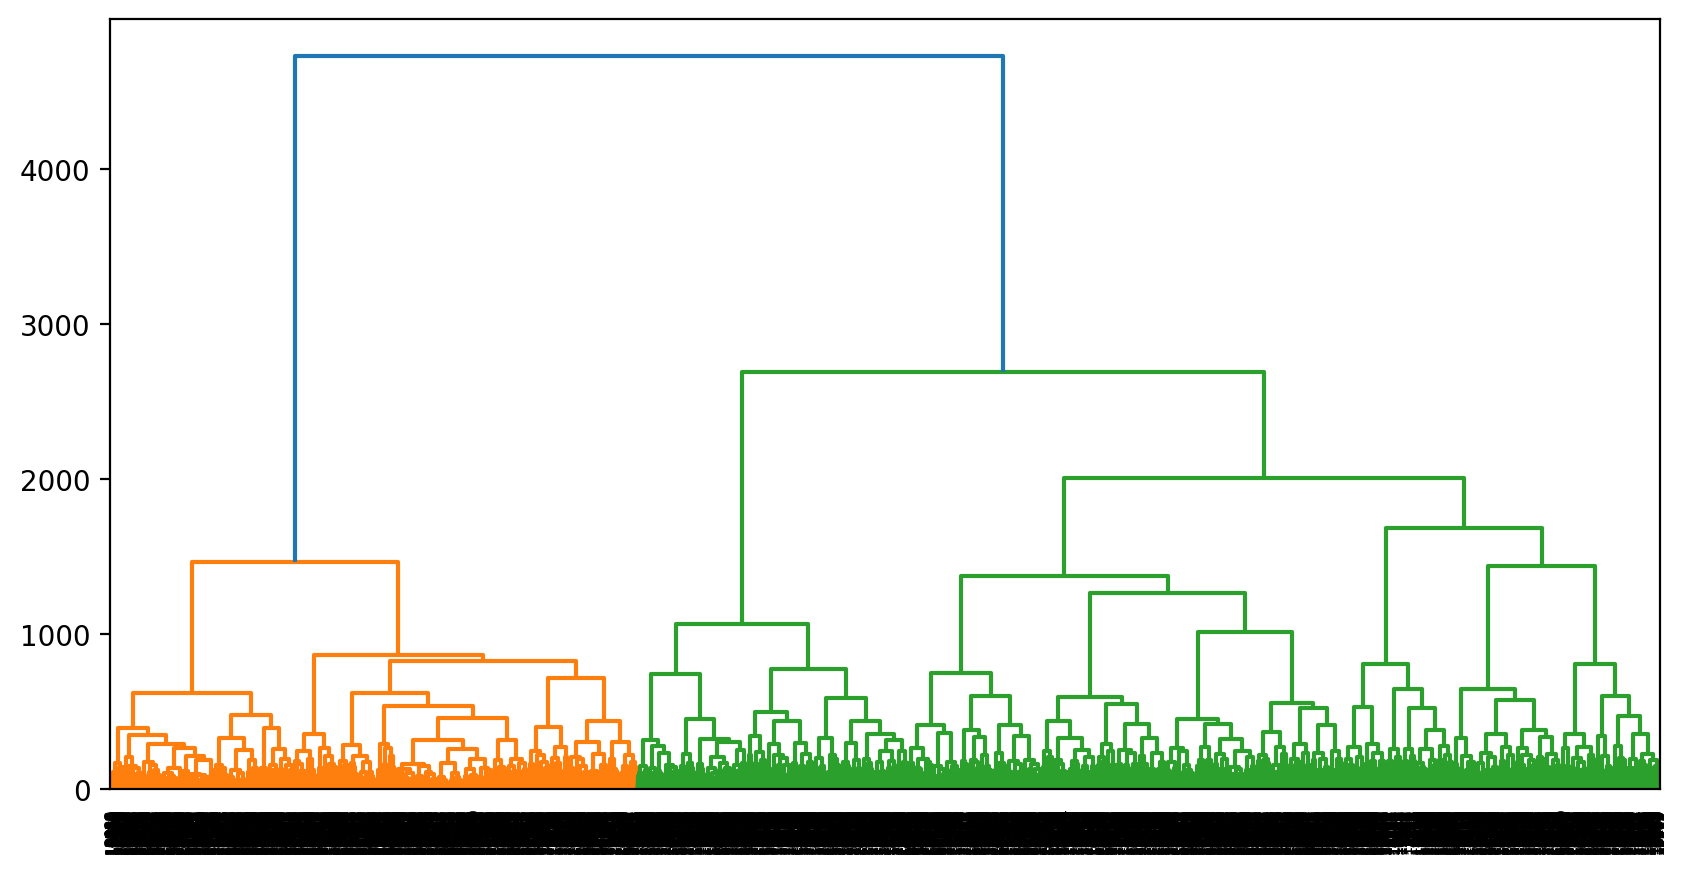

In [7]:
Z = hierarchy.linkage(X_pca, method='ward')
plt.figure(figsize=(10,5), dpi=200, facecolor='w', edgecolor='k')
hierarchy.dendrogram(Z)
plt.show()

Widać teraz, że dobrym kandydatem na *distance_threshold* jest ok. 1750, bowiem od tej wartości zmiany zaczynają zachodzić znacznie szybciej niż dla wyższych oraz liczba klastrów (6) jest akceptowalna.\
Inaczej patrząc, od *liczby klastrów* = 5 przedziały możliwych wartości odległości między punktami są dużo mniejsze.


### 4.2. Analiza metryk
Przeanalizujemy model aglomeracyjnej klasteryzacji o *liczbie klastrów* = 5. Rozważymy różne metryki *linkage*.

In [31]:
metrices = {
            'silhouette': silhouette_score,
            'davies - bouldin' : davies_bouldin_score,
            'calinski - harabasz' : calinski_harabasz_score,
            'dunn' : calculate_dunn_index
           }

models = {
          'Agglomerative ward linkage': partial(AgglomerativeClustering, linkage='ward'),
          'Agglomerative complete linkage': partial(AgglomerativeClustering, linkage='complete'),
          'Agglomerative average linkage': partial(AgglomerativeClustering, linkage='average'),
          'Agglomerative single linkage': partial(AgglomerativeClustering, linkage='single'),
         }

df = pd.DataFrame()
for model_key in models:
    for metric_key in metrices:
        print(f"Processing model: {model_key}, metric: {metric_key}")  # Debug print
        score =  count_clustering_scores(X=X_pca, cluster_num=5, model=models[model_key], score_fun=metrices[metric_key])
        df.loc[model_key, metric_key] = score
df

Processing model: Agglomerative ward linkage, metric: silhouette
Processing model: Agglomerative ward linkage, metric: davies - bouldin
Processing model: Agglomerative ward linkage, metric: calinski - harabasz
Processing model: Agglomerative ward linkage, metric: dunn
Processing model: Agglomerative complete linkage, metric: silhouette
Processing model: Agglomerative complete linkage, metric: davies - bouldin
Processing model: Agglomerative complete linkage, metric: calinski - harabasz
Processing model: Agglomerative complete linkage, metric: dunn
Processing model: Agglomerative average linkage, metric: silhouette
Processing model: Agglomerative average linkage, metric: davies - bouldin
Processing model: Agglomerative average linkage, metric: calinski - harabasz
Processing model: Agglomerative average linkage, metric: dunn
Processing model: Agglomerative single linkage, metric: silhouette
Processing model: Agglomerative single linkage, metric: davies - bouldin
Processing model: Agglome

silhouette  davies - bouldin  \
Agglomerative ward linkage        0.115659          2.516269   
Agglomerative complete linkage    0.080207          3.020582   
Agglomerative average linkage     0.095798          1.074010   
Agglomerative single linkage      0.106609          0.677905   

                                calinski - harabasz      dunn  
Agglomerative ward linkage              1905.770723  0.088609  
Agglomerative complete linkage          1496.291827  0.072993  
Agglomerative average linkage              8.770352  0.180113  
Agglomerative single linkage               2.177528  0.308695

### 4.3. Wybór modelu

W świetle powyższych czterech metryk, aż 3 osiągają najlepszy wynik dla **linkage = single**. Jest jednak niejedno **ALE**:
- model aglomerative z linkage = single tworzy 5 klastrów, w tym cztery z nich są 0 lub 1-elementowe,
- podobnie model aglomerative z linkage = average.  
Zatem spośród pozostałych dwóch, w każdej metryce lepiej wypada model aglomerative z **linkage = ward**.

In [10]:
model_hierarchy = AgglomerativeClustering(n_clusters=5, linkage='ward')

### 4.4. Weryfikacja klastrów

In [11]:
# add 'cluster column to the dataframe
X_pca_predicted = X_pca.copy()
X_pca_predicted['cluster'] = model_hierarchy.fit_predict(X_pca)

In [12]:
# number of samples in each cluster
cluster_sizes = X_pca_predicted['cluster'].value_counts()
print(cluster_sizes)

cluster
0    5296
3    4381
2    2703
1    2074
4    1103
Name: count, dtype: int64


Zatem liczba obrazów w klastrach przedstawia się następująco:    
0    5296  
3    4381  
2    2703  
1    2074  
4    1103

### 4.5. Przegląd obrazów w klastrach.

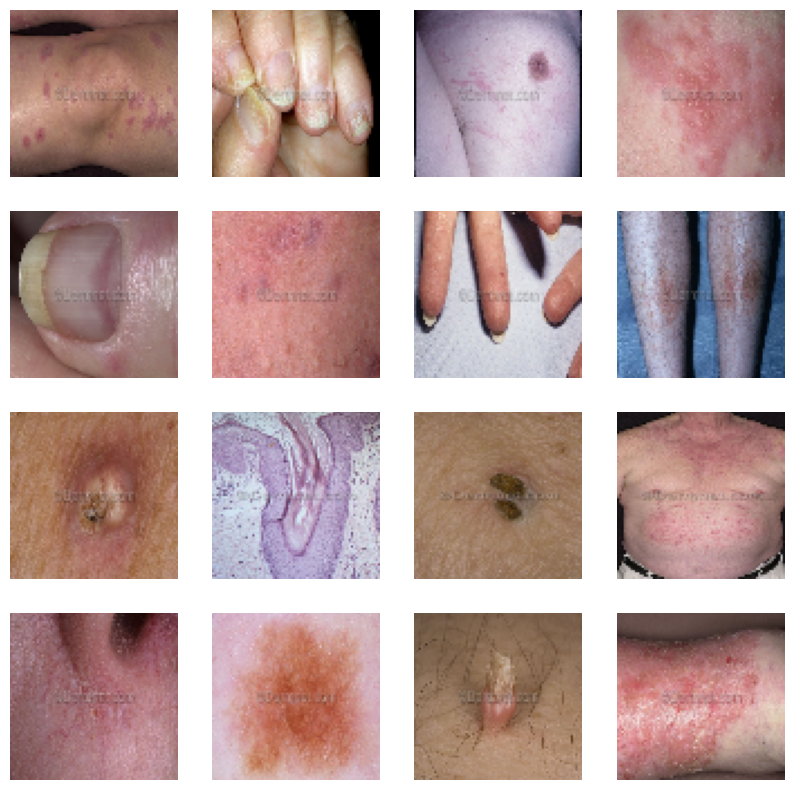

In [35]:
clusters = X_pca_predicted['cluster'].unique().tolist()
selected_images = {cluster : [] for c in clusters}
random.seed(2137)
for cluster in clusters:
    cluster_indices = X_pca_predicted[X_pca_predicted['cluster'] == cluster].index
    selected_indices = random.sample(list(cluster_indices), 16)
    selected_images[cluster] = X.iloc[selected_indices]['image'].values
# visualize 
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for j in range(16):
    axes[j//4, j%4].imshow(selected_images[0][j])
    axes[j//4, j%4].axis('off')

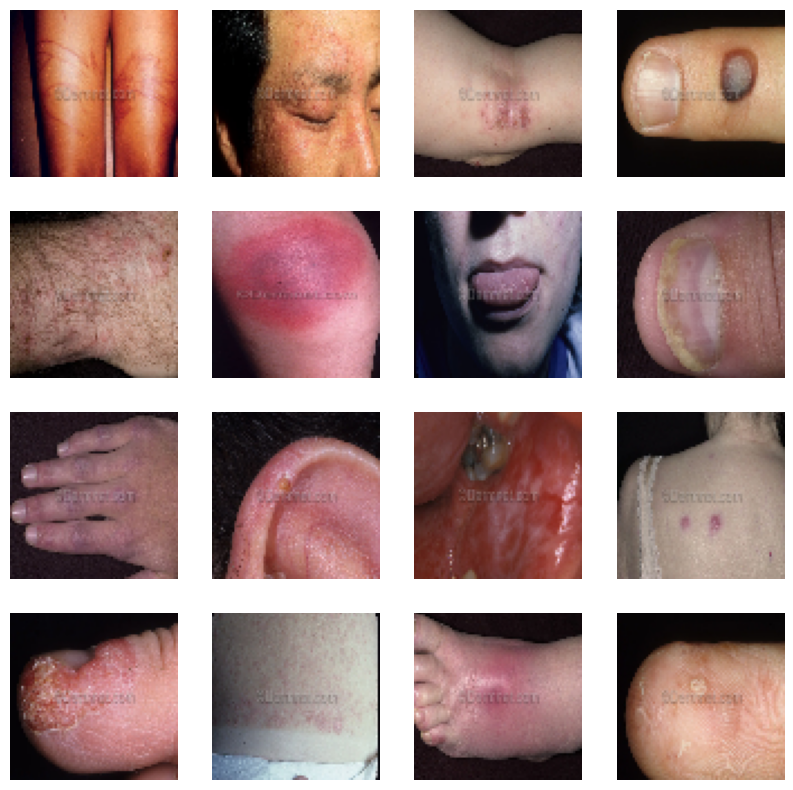

In [36]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for j in range(16):
    axes[j//4, j%4].imshow(selected_images[1][j])
    axes[j//4, j%4].axis('off')

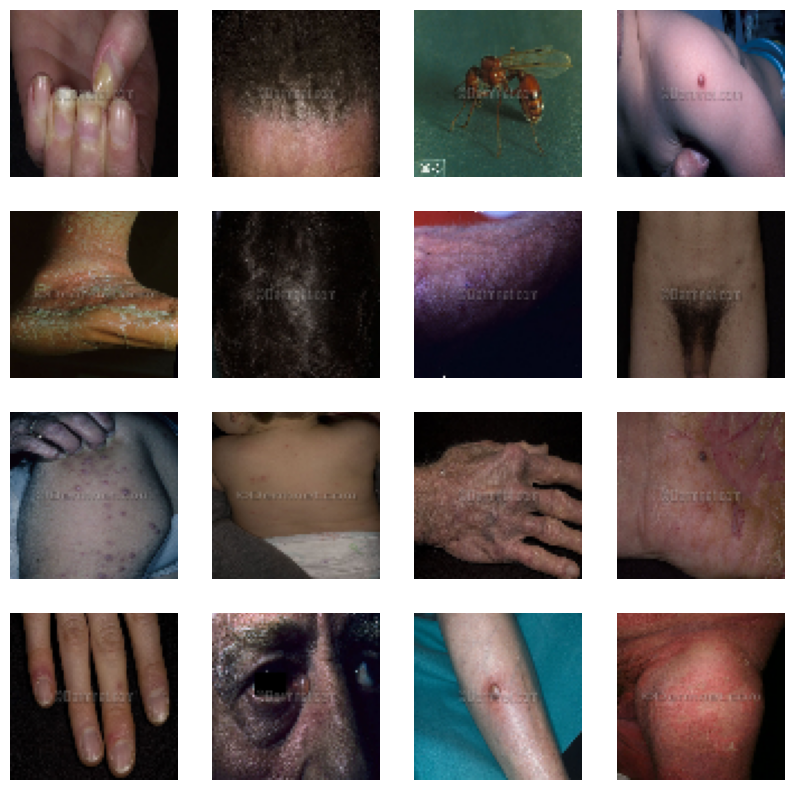

In [37]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for j in range(16):
    axes[j//4, j%4].imshow(selected_images[2][j])
    axes[j//4, j%4].axis('off')

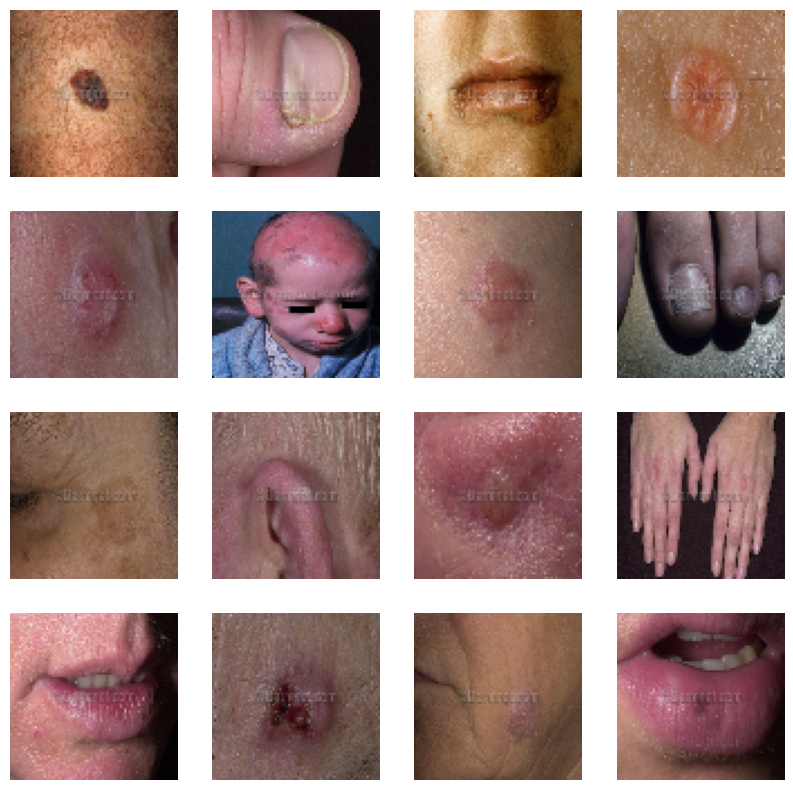

In [38]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for j in range(16):
    axes[j//4, j%4].imshow(selected_images[3][j])
    axes[j//4, j%4].axis('off')

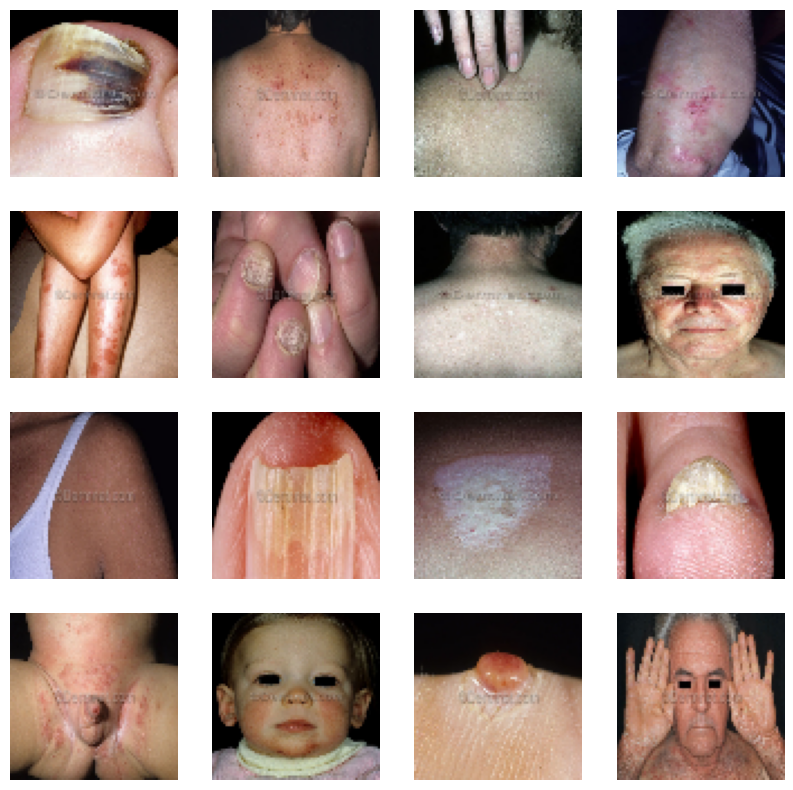

In [39]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for j in range(16):
    axes[j//4, j%4].imshow(selected_images[4][j])
    axes[j//4, j%4].axis('off')

### 4.6. Wnioski
- obrazy w klastrach nie są do siebie podobne.